Playground for developing encoding schemes.

Sources:
- A Transformer-based Framework for Multivariate Time Series Representation Learning: <https://arxiv.org/abs/2010.02803>

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # https://stackoverflow.com/a/64438413
path = os.path.abspath('..')
if path not in sys.path:
    sys.path.append(path)

from __future__ import annotations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras

import makassar_ml as ml

In [27]:
DATASET_ROOT = Path('~/research/makassar/datasets').expanduser()
if not DATASET_ROOT.exists(): raise ValueError(f"Dataset root directory does not exist at {DATASET_ROOT}")
PROJECT_ROOT = Path('~/research/makassar').expanduser()
CHECKPOINT_ROOT = PROJECT_ROOT / 'checkpoints'
IMAGE_ROOT = PROJECT_ROOT / 'images'
TABLE_ROOT = PROJECT_ROOT / 'tables'
HP_TUNING_ROOT = PROJECT_ROOT / 'hp_tuning'
KERAS_TUNER_PATH = PROJECT_ROOT / 'keras_tuner'

# Ensure some directories exist.
PROJECT_ROOT.mkdir(parents=True, exist_ok=True)
CHECKPOINT_ROOT.mkdir(parents=True, exist_ok=True)
IMAGE_ROOT.mkdir(parents=True, exist_ok=True)
TABLE_ROOT.mkdir(parents=True, exist_ok=True)
HP_TUNING_ROOT.mkdir(parents=True, exist_ok=True)
KERAS_TUNER_PATH.mkdir(parents=True, exist_ok=True)

Epoch 1/10
229/229 [==============================] - 6s 15ms/step - loss: 1.0599 - mae: 0.8575 - mape: 138.2675 - val_loss: 0.9066 - val_mae: 0.7721 - val_mape: 112.5732

Epoch 00001: val_loss improved from inf to 0.90663, saving model to /home/acd1797/research/makassar/checkpoints/transformer_linear_embed_linear_encode/model.h5
Epoch 2/10
229/229 [==============================] - 3s 13ms/step - loss: 1.0348 - mae: 0.8330 - mape: 107.8067 - val_loss: 0.9269 - val_mae: 0.7703 - val_mape: 116.3904

Epoch 00002: val_loss did not improve from 0.90663
Epoch 3/10
229/229 [==============================] - 3s 13ms/step - loss: 1.0268 - mae: 0.8277 - mape: 106.2197 - val_loss: 0.9753 - val_mae: 0.7726 - val_mape: 141.6941

Epoch 00003: val_loss did not improve from 0.90663
Epoch 4/10
229/229 [==============================] - 3s 13ms/step - loss: 1.0186 - mae: 0.8228 - mape: 106.9098 - val_loss: 1.0716 - val_mae: 0.7830 - val_mape: 200.5590

Epoch 00004: val_loss did not improve from 0.90663

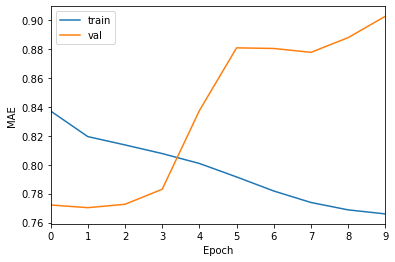

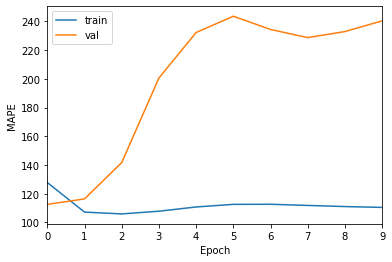

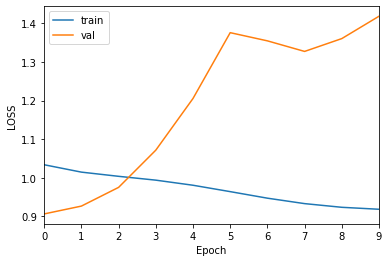

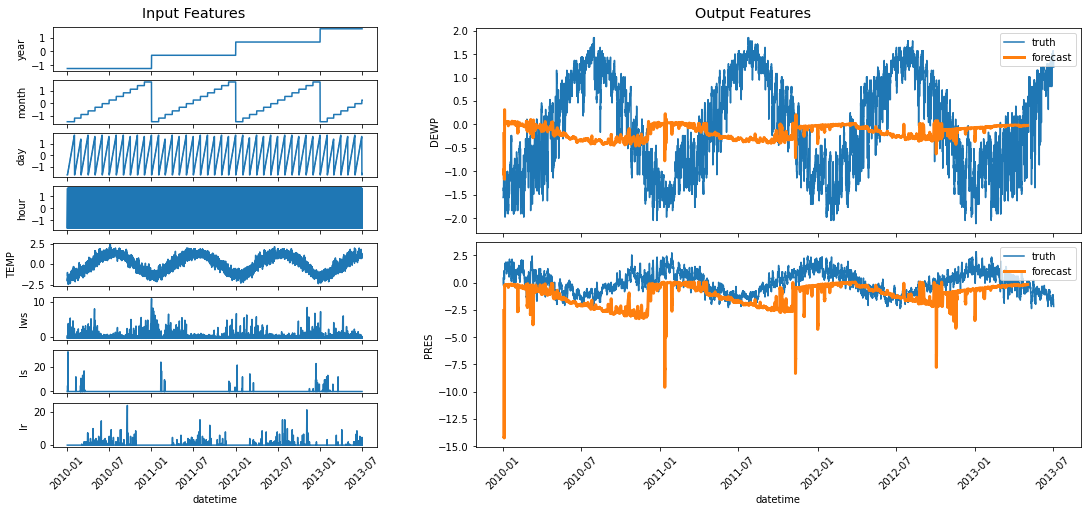

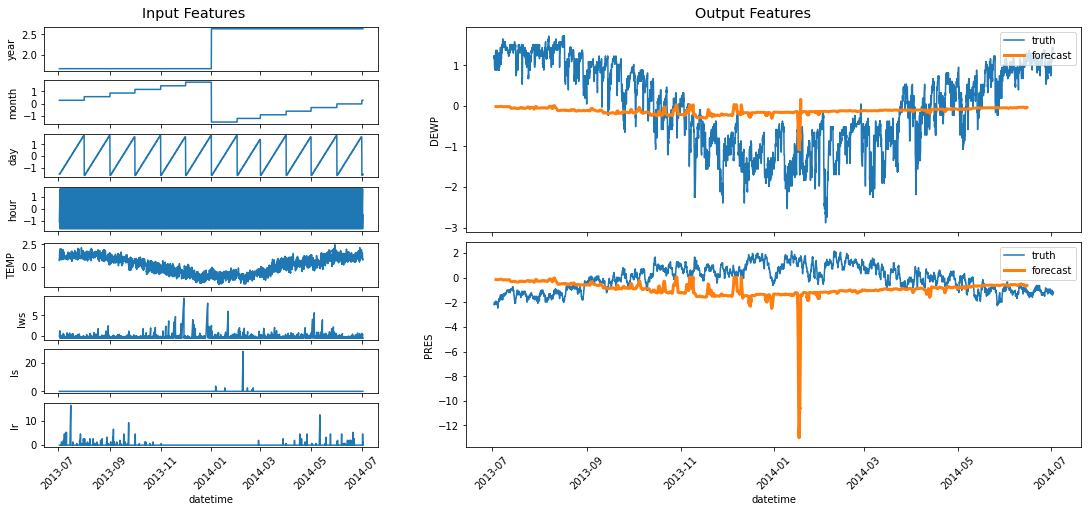

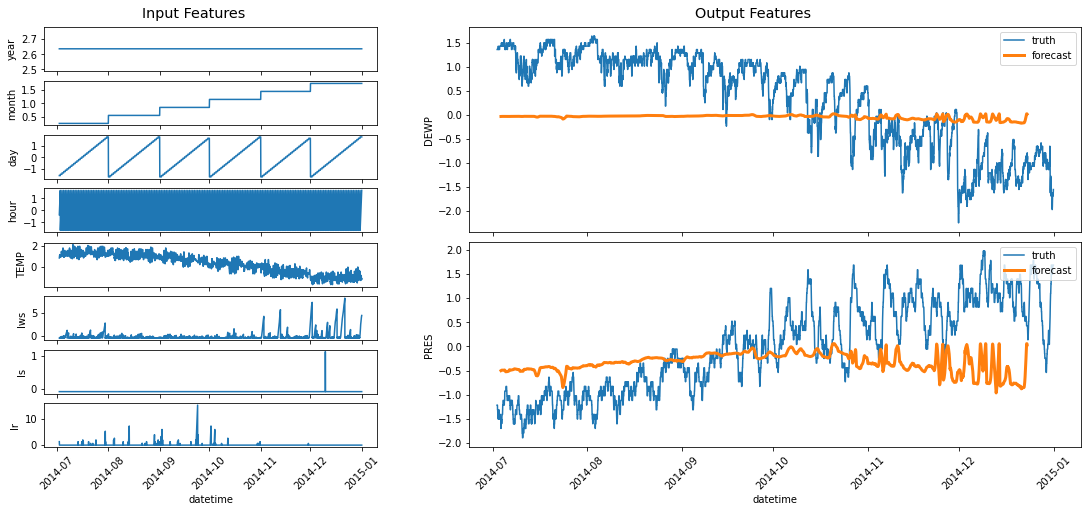

In [52]:
# Define data and training parameters.
epochs = 10
in_seq_len = 30
out_seq_len = 1
shift = 1
split = (0.7,0.2,0.1)
# in_feat = ['year','month','day','hour','pm2.5','DEWP','TEMP','PRES','Iws','Is','Ir']
# in_feat = ['year','month','day','hour','DEWP']
# in_feat = ['DEWP']
# in_feat = ['TEMP','PRES','Iws','Is','Ir']
in_feat = ['year','month','day','hour','TEMP','Iws','Is','Ir']
# out_feat = ['DEWP']
out_feat = ['DEWP', 'PRES']
batch_size = 128
shuffle = False
strategy = tf.distribute.get_strategy()

# Load the dataset to determine total number of training batches.
dataset_train, _, _ = ml.datasets.beijingpm25.load_beijingpm25_ds(
    in_seq_len=in_seq_len,
    out_seq_len=out_seq_len,
    shift=shift,
    in_feat=in_feat,
    out_feat=out_feat,
    split=split,
    shuffle=shuffle,
    path=DATASET_ROOT/'beijing_pm25',
    batch_size=batch_size,
)
batches = tf.data.experimental.cardinality(dataset_train).numpy()
del dataset_train # Free memory.



# Create learning rate schedule.
n_steps = epochs*batches
lr_schedule = ml.schedules.LinearWarmupLearningRateScheduleWrapper(
    keras.experimental.CosineDecay
    )(
    warmup_learning_rate=0.0,
    warmup_steps=500,
    initial_learning_rate=1e-3,
    decay_steps=n_steps,
)

# Define model compilation parameters.
# (i.e., loss, metrics, etc.)
compile_params = dict(
    loss='mse',
    metrics=['mae', 'mape'],
)

def build_model_func() -> keras.Model:
    # Model hyperparameters.
    hparams = dict(
        in_seq_len=in_seq_len,
        in_feat=len(in_feat),
        out_feat=len(out_feat),
        fc_units=[64,64],
        embed_dim=4,
        n_heads=8,
        ff_dim=2048,
        dropout=0.1,
        n_encoders=3,
    )

    # Build model.
    inp = keras.Input(shape=(hparams['in_seq_len'], hparams['in_feat']))
    x = inp
    x = ml.layers.LinearEmbedding2D(embed_dim=hparams['embed_dim'])(x)
    x = ml.layers.LinearEncoding2D()(x)
    for _ in range(hparams['n_encoders']):
        x = ml.layers.TransformerEncoderLayer(
            model_dim=hparams['embed_dim'],
            key_dim=None,
            n_heads=hparams['n_heads'],
            ff_dim=hparams['ff_dim'],
            value_dim=None,
            dropout=hparams['dropout'],
        )(x)
    # Downsample to the original sequence dimension.
    # x = keras.layers.GlobalAvgPool1D(data_format='channels_first')(x) # shape=(in_seq_len,)
    x = keras.layers.GlobalAvgPool1D(data_format='channels_last')(x) # shape=(in_seq_len,)
    x = keras.layers.Dropout(rate=hparams['dropout'])(x)
    # Fully-connected network before classifier.
    for units in hparams['fc_units']: 
        x = keras.layers.Dense(units=units, activation='relu')(x)
        x = keras.layers.Dropout(rate=hparams['dropout'])(x)
    # Classifier.
    x = keras.layers.Dense(units=hparams['out_feat'], activation='linear')(x)
    # Construct model class and return.
    model = keras.Model(inputs=inp, outputs=x)

    # Configure optimizer.
    optim = keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compile the model.
    model.compile(optimizer=optim, loss=compile_params['loss'], metrics=compile_params['metrics'])
    return model

def dataset_loader_func(batch_size: int) -> tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    return ml.datasets.beijingpm25.load_beijingpm25_ds(
        in_seq_len=in_seq_len,
        out_seq_len=out_seq_len,
        shift=shift,
        in_feat=in_feat,
        out_feat=out_feat,
        split=split,
        shuffle=shuffle,
        path=DATASET_ROOT/'beijing_pm25',
        batch_size=batch_size,
    )

# Train and evaluate the model.
model, hist, met = ml.training.train_evaluate_for_dataset(
    model_name='transformer_linear_embed_linear_encode',
    build_model_func=build_model_func,
    dataset_loader_func=dataset_loader_func,
    metric_list=compile_params['metrics'],
    batch_size=batch_size,
    strategy=strategy,
    epochs=epochs,
    checkpoint_root=CHECKPOINT_ROOT,
)

# Plot train/val performance.
for key in compile_params['metrics']+['loss']:
    fig = ml.visualization.plot_metric(hist, key)
    # fig.savefig(image_root/f"{model_name}_{key}.png", bbox_inches='tight')
    fig.show()


# Load the data in dataframe form.
df_train, df_val, df_test = ml.datasets.beijingpm25.load_beijingpm25_df(
    split=split,
    path=DATASET_ROOT/'beijing_pm25',
)
# Load the data in dataset form.
dataset_train, dataset_val, dataset_test = ml.datasets.beijingpm25.load_beijingpm25_ds(
    in_seq_len=in_seq_len,
    out_seq_len=out_seq_len,
    shift=shift,
    in_feat=in_feat,
    out_feat=out_feat,
    split=split,
    shuffle=shuffle,
    path=DATASET_ROOT/'beijing_pm25',
    batch_size=batch_size,
)
# Data keys.
keys = [
    'year',
    'month',
    'day',
    'hour',
    'pm2.5',
    'DEWP',
    'TEMP',
    'PRES',
    'Iws',
    'Is',
    'Ir',
]
# Normalize specific keys.
train_mean = df_train[keys].mean()
train_std = df_train[keys].std()
df_train[keys] = (df_train[keys] - train_mean)/train_std
df_val[keys] = (df_val[keys] - train_mean)/train_std
df_test[keys] = (df_test[keys] - train_mean)/train_std
# Evaluate the model on the train/val/test data.
train_pred = model.predict(dataset_train)
val_pred = model.predict(dataset_val)
test_pred = model.predict(dataset_test)
print(f"{train_pred.shape=}")
print(f"{val_pred.shape=}")
print(f"{test_pred.shape=}")
# Plot the model predictions of the dataset.
# Create figure for each data set.
figs = {}
labels = ['train', 'val', 'test']
for l, label in enumerate(labels):
    fig = ml.visualization.plot_input_output(
        df=locals()[f"df_{label}"],
        pred=locals()[f"{label}_pred"],
        in_seq_len=in_seq_len,
        out_seq_len=out_seq_len,
        shift=shift,
        in_feat=in_feat,
        out_feat=out_feat,
        x_key='datetime',
    )
    # fig.suptitle(f"{label[0].upper()}{label[1:]} Data", fontsize='xx-large')
    figs[label] = fig
for name, fig in figs.items():
    # fig.savefig(IMAGE_ROOT/f"{model_name}_io_{name}.png", bbox_inches='tight')
    fig.show()

In [53]:
# Model hyperparameters.
hparams = dict(
    in_seq_len=in_seq_len,
    in_feat=len(in_feat),
    out_feat=len(out_feat),
    fc_units=[64,64],
    embed_dim=4,
    n_heads=8,
    ff_dim=2048,
    dropout=0.1,
    n_encoders=3,
)

# Build model.
inp = keras.Input(shape=(hparams['in_seq_len'], hparams['in_feat']))
x = inp
print(f"{x.shape=}")
x = ml.layers.LinearEmbedding2D(embed_dim=hparams['embed_dim'])(x)
print(f"{x.shape=}")
x = ml.layers.LinearEncoding2D()(x)
print(f"{x.shape=}")
print('encoders')
for _ in range(hparams['n_encoders']):
    x = ml.layers.TransformerEncoderLayer(
        model_dim=hparams['embed_dim'],
        key_dim=None,
        n_heads=hparams['n_heads'],
        ff_dim=hparams['ff_dim'],
        value_dim=None,
        dropout=hparams['dropout'],
    )(x)
    print(f"{x.shape=}")
print('pool')
# Downsample to the original sequence dimension.
# x = keras.layers.GlobalAvgPool1D(data_format='channels_first')(x) # shape=(in_seq_len,)
x = keras.layers.GlobalAvgPool1D(data_format='channels_last')(x) # shape=(in_seq_len,)
print(f"{x.shape=}")
x = keras.layers.Dropout(rate=hparams['dropout'])(x)
print(f"{x.shape=}")
print('fc')
# Fully-connected network before classifier.
for units in hparams['fc_units']: 
    x = keras.layers.Dense(units=units, activation='relu')(x)
    x = keras.layers.Dropout(rate=hparams['dropout'])(x)
    print(f"{x.shape=}")
print('classifier')
# Classifier.
x = keras.layers.Dense(units=hparams['out_feat'], activation='linear')(x)
print(f"{x.shape=}")

# # Construct model class and return.
# model = keras.Model(inputs=inp, outputs=x)

# # Configure optimizer.
# optim = keras.optimizers.Adam(learning_rate=lr_schedule)

# # Compile the model.
# model.compile(optimizer=optim, loss=compile_params['loss'], metrics=compile_params['metrics'])

x.shape=TensorShape([None, 30, 8])
x.shape=TensorShape([None, 30, 4])
x.shape=TensorShape([None, 30, 4])
encoders
x.shape=TensorShape([None, 30, 4])
x.shape=TensorShape([None, 30, 4])
x.shape=TensorShape([None, 30, 4])
pool
x.shape=TensorShape([None, 4])
x.shape=TensorShape([None, 4])
fc
x.shape=TensorShape([None, 64])
x.shape=TensorShape([None, 64])
classifier
x.shape=TensorShape([None, 2])


In [46]:
x = tf.zeros((1234,30,2))
print(f"{x.shape=}")
print(f"{tf.reshape(x, shape=(-1, x.shape[-1])).shape=}")


tf.reshape([[1,2,3],[4,5,6],[7,8,9]], shape=(-1))

x.shape=TensorShape([1234, 30, 2])
tf.reshape(x, shape=(-1, x.shape[-1])).shape=TensorShape([37020, 2])


<tf.Tensor: shape=(9,), dtype=int32, numpy=array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>